# HW2: Spam classification with LSTM

The deadline is **9:30 am Feb 16, 2022**.   
You should submit a `.ipynb` file with your solutions to NYU Brightspace.

---

In this homework, we will reuse the spam prediction dataset used in HW1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).

Lab 3 is especially relevant to this homework.

## Points distribution

1. code `spam_collate_func`: 25 pts
2. code `LSTMClassifier.init`: 25 pts
3. code `LSTMClassifier.forward`: 20 pts
4. code `evaluate`: 10 pts
5. code for training loop: 10 pts
6. Question on early stopping: 10 pts

How we grade the code: 
- full points if code works and the underlying logic is correct;
- half points if code works but the underlying logic is incorrect;
- zero points if code does not work.

Therefore, **make sure your code works, i.e., no error is being produced when you execute the code.**


# Data Loading
First, reuse the code from HW1 to download and read the data.

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv 

zsh:1: command not found: wget


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [3]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [4]:
train_texts[:10]  # Just checking the examples in train_text

['Haha, my friend tyler literally just asked if you could get him a dubsack',
 'Hi there. We have now moved in2 our pub . Would be great 2 c u if u cud come up.',
 "Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs",
 'No break time one... How... I come out n get my stuff fr Ì_?',
 'URGENT! We are trying to contact you. Last weekends draw shows that you have won a å£900 prize GUARANTEED. Call 09061701851. Claim code K61. Valid 12hours only',
 "R Ì_ going 4 today's meeting?",
 'Yo we are watching a movie on netflix',
 'Can i meet Ì_ at 5.. As 4 where depends on where Ì_ wan 2 in lor..',
 'Yup song bro. No creative. Neva test quality. He said check review online.',
 "I'm in a movie. Call me 4 wat?"]

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.


This is related Lab 3 Deep Learning, please watch the recording and check the notebook for details.


In [5]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://'docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu' -O glove_split.aa
!wget https://'docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY ' -O glove_split.ab
!wget https://'docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f' -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


## Load GloVe Embeddings

In [6]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
        print(embedding_ls[-1].size)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

300


## Import packages

In [7]:
#!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [8]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [9]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[1, 3, 194, 1411, 8960, 5919, 122, 478, 85, 83, 96, 171, 105, 9, 1], [11085, 1, 55, 35, 116, 556, 1, 164, 10451, 4, 56, 32, 355, 234, 1866, 6481, 85, 6481, 1, 328, 62, 4], [8609, 1, 6481, 1, 53, 2862, 6, 1, 39, 16, 164, 296, 1268, 6, 1873, 6481, 807, 1, 8733, 6, 1, 1, 276, 1, 276, 1, 276, 1, 276, 2309, 276, 1, 1, 1], [86, 1131, 81, 50, 436, 199, 436, 43, 328, 68, 3816, 171, 194, 3498, 15990, 1, 99, 190], [2413, 807, 55, 34, 597, 6, 1873, 1, 78, 8260, 1709, 972, 14, 83, 35, 229, 9, 1, 4552, 6538, 1938, 1, 582, 1, 1549, 2282, 1, 7045, 1, 93]]

Train labels first 5 examples:
 [0, 0, 1, 0, 1]


# Create DataLoaders (25 pts)
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is less than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  

Please check the comment block in the code near TODO for more details.


Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset
from itertools import repeat, chain, islice #Import necessary Libraries
class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]
    
    def spam_collate_func(self, batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        # What the input `batch`? That's for you to figure out!
        # You can read the Dataloader documentation, or you can use print
        # function to debug. 
        """ 
        data_list = [] # store padded sequences
        label_list = []

        # the length of longest sequence in batch if it is less than self.max_sent_length else max_batch_seq_len = self.max_sent_length
        max_batch_seq_len = max([len(d[0]) for d in batch]) #Find the largest batch
        max_batch_seq_len = min(max_batch_seq_len, self.max_sent_length) #Take the min as the ceiling for batch size

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here 
        """
        #Iterate over the batch
        for data_arr, label in batch:
            #Use some itertools libraries to help pad the batches with 0s if necessary
            padded_data_arr = list(islice(chain(data_arr, repeat(0)), max_batch_seq_len))
            
            #Append the padded data
            data_list.append(padded_data_arr)
            label_list.append(label)

        #Make the data list to become tensors for our batches
        data_list,label_list = torch.Tensor(data_list).long(), torch.Tensor(label_list).long()
        
        #Return the tensors
        return [data_list, label_list]


BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an batch from train_loader.


In [11]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 52])
data_batch:  tensor([[ 1000,  4963,    14,  ...,     0,     0,     0],
        [10576,  1953,     9,  ...,     0,     0,     0],
        [12189,  8863,  3225,  ...,     0,     0,     0],
        ...,
        [   83,    90,   394,  ...,     0,     0,     0],
        [14208,     3,    43,  ...,     0,     0,     0],
        [    1,     0,     0,  ...,     0,     0,     0]])
labels:  tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Build a BiLSTM Classifier (20 + 25 + 10 pts)

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference. Recall that we've also seen LSTM in Lab 3. 

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [12]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        #We can use a Pytorch function, dropout, to 0 out features with probability p for each element
        #This helps with regularizing our model
        """
           Define the components of your BiLSTM Classifier model
           2. TODO: Your code here
        """
        #Utilize nn Pyorch library for dropout
        self.dropout = nn.Dropout(p=dropout_prob) #Default set to .3
        #Max pooling method
        self.pool = nn.AdaptiveMaxPool1d(1)
        #Use Pytorch, LSTM, to create an object that acts as
        #a multi-layer long short-term memory (LSTM) RNN 
        self.lstm = nn.LSTM(
            #Update the parameters accordingly
            input_size=embeddings.shape[-1],
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_prob
        )
        #Use ReLu for a non_linear layer, as suggested by the notes
        self.non_linearity = nn.ReLU()
        #Add classification layer as we will need this in our final step
        #To predict a certain value 
        self.clf = nn.Linear(hidden_size*2, num_classes)  # Specify number of classes in vs out
        
        #Create method for model, use nn.Sequential to specify NN Layering
        #And to chain input output between steps
        # Use the example format: forward := embedding -> bilstm -> pooling (sum?mean?max?) nonlinearity -> classifier
        # But also add another non_linearity layer just for spice
        self.model = nn.Sequential(
                                        #Begin by embedding data 
                                        self.embedding_layer,
                                        self.dropout, #Utilize Dropout after embedding inputs
                                        self.lstm,
                                        self.non_linearity, #Both are ReLu
                                        self.clf #Then classify using nn.Linear
                                    )
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 3 Deep Learning
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None
        """
           Write forward pass for LSTM. You must use dropout after embedding
           the inputs. 

           Example, forward := embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364

           Return logits

           3. TODO: Your code here
        """
        #Embedd the inputs:
        embedded_inputs = self.embedding_layer(inputs)
        #Per the exmample in the triple quotes, following the embedding with drouput
        dropped_embedded_inputs = self.dropout(embedded_inputs)
        #Then call our bilstm, which returns the following:
        #Output: Contains the output features (h_t) from the last layer of the LSTM, for each t. 
        # H_n:  The final hidden state for each element in the batch.
        # C_n:  containing the final cell state for each element in the batch.
        output, (h_n, c_n) = self.lstm(dropped_embedded_inputs)
        #Add a permutation layer
        output = output.permute(0,2,1)
        #Max Pool the layer
        hidden = self.pool(output)
        hidden = torch.squeeze(hidden)
        #Apply non-linearity function
        hidden = self.non_linearity(hidden)
        #Lastly apply linear classification model
        out = self.clf(hidden)
        
        #We apply the softmax to our logits to get probabilities
        logits = F.log_softmax(out)
        #Return the logitis when forward() is called
        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [13]:
def evaluate(model, dataloader, labels, device):
    accuracy = None
    #Switch the model to evaluate mode, turning off dropout layers
    #model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab 3 part 1.
    """
    #Use the model on testing data
    #use With torch.no_grad() to avoid calculating gradients during testing (only necessary during training)
    with torch.no_grad():
        #Helper variables
        prediction_arr = []
        #Iterate through dataloader
        for batch_text, batch_labels in dataloader:
            #Code written in reference to 'run_inference' function from Lab 3 Part 1
            prediction = model(batch_text.to(device))
            prediction_arr.append(prediction.detach().cpu().numpy())
    #Save a step by concatenating and taking argmax
    prediction = np.concatenate(prediction_arr, axis=0).argmax(-1)
    #Calculate the accuracy
    accuracy = (labels==prediction).mean()
    #Return the accuracy 
    return accuracy

# Initialize the BiLSTM classifier model, criterion and optimizer


In [14]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Train model with early stopping (10 pts)

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [15]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()  # this enables dropout/regularization
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        """
          5(1). TODO: Recall that pytorch training involves five critical
          components, as discussed in the Lab. Some of the components are
          still missing here. Your code here.
        """
        #We are still missing the step to use backpropogation for gradient descent calculations
        loss.backward()
        #Take a step
        optimizer.step()
        #Then clear the gradient
        optimizer.zero_grad()
        #Append training loss to our return variable
        train_loss_history.append(loss.item())
        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5(2). TODO: Your code here
    """
    #Retrieve the accuracy via the evaluate function we just completed
    accuracy = evaluate(model, val_loader, val_labels, device)
    #If we keep getting better, update the model and continue training
    if best_val_accuracy < accuracy : #Strict inequality
        #Use hint to save the best performing model
        torch.save(model, 'best_model.pt')
        #Update best accuracy
        best_val_accuracy = accuracy
    else:
        #If we haven't improved x times, break the loop
        if early_stop_patience < n_no_improve:
            break
    #Otherwise continue and increment n_no_improve
    n_no_improve += 1
    #Append the accuracy
    val_accuracy_history.append(accuracy)

print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/rk/rwsr6gss0vz3g4fz3_kt0x0m0000gn/T/ipykernel_16460/2593934900.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.log_softmax(out)


Best validation accuracy is:  0.9916167664670659


# Question: Why do we want to use early stopping? Write the most important reason in concise way. (10 pts)

#### Your answer: 

We like to use early stopping as a form of regulurization. This way, we train our model to perform the best on validation and testing sets as a measure to ensure that the model will generalize to real world situations the best, (and thus actually be useful). Overiffiting on training data can lead to poor performance on test set data, and if we let our RNN run long enough, and the model continues to optimize its parameters with respect to the training data, it will not generalize at all to any real world task and be without use.

# Draw training curve 
X-axis: training steps, Y-axis: training loss

Make sure to draw your own curves. 

<AxesSubplot:>

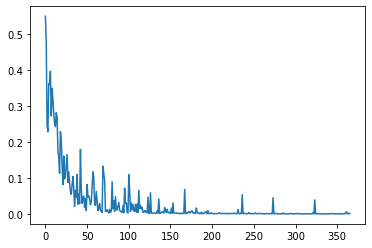

In [16]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

<AxesSubplot:>

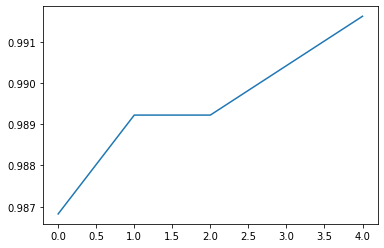

In [17]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy > 0.95.

In [18]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, test_labels,device)
print(test_accuracy)

/var/folders/rk/rwsr6gss0vz3g4fz3_kt0x0m0000gn/T/ipykernel_16460/2593934900.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.log_softmax(out)


0.9844311377245509
